In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from roidetection import draw_rois
import joblib
from skimage.util.shape import view_as_blocks
import time

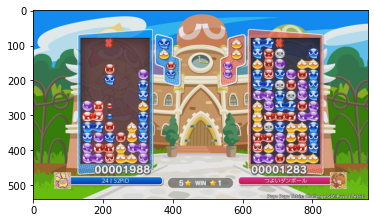

In [2]:
im = Image.open('test-images/amitie_witch.png').convert('RGB')
im = im.resize((960, 540))
im = np.array(im)
plt.imshow(im)
plt.show()

[[136  79 200 361]
 [624  79 199 361]]


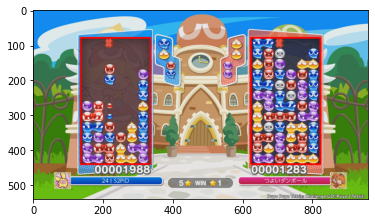

In [3]:
field_rois = np.array([[136,  79, 200, 361], [624,  79, 199, 361]])
print(field_rois)
im_roi = draw_rois(im, [field_rois])
plt.imshow(im_roi)
plt.show()

In [4]:
def crop_im(im, roi):
    x0, x1 = roi[0], roi[0] + roi[2]
    y0, y1 = roi[1], roi[1] + roi[3]
    return im[y0:y1, x0:x1]

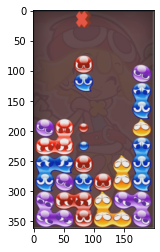

In [5]:
p1_field = crop_im(im, field_rois[0])
plt.imshow(p1_field)
plt.show()

In [6]:
def crop_centered_field(field_im):
    orig_height, orig_width = field_im.shape[:2]

    target_height = 30 * 12
    target_width = 32 * 6

    diff_x = orig_width - target_width
    diff_y = orig_height - target_height

    x0 = diff_x // 2
    y0 = diff_y // 2
    x1 = x0 + 32 * 6
    y1 = y0 + 30 * 12

    return field_im[y0:y1, x0:x1]

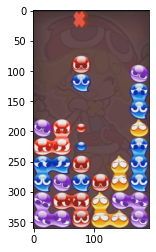

In [7]:
p1_field_centered = crop_centered_field(p1_field)
plt.imshow(p1_field_centered)
plt.show()

In [8]:
def get_cell(im, row, col):
    x0 = col * 32
    x1 = (col + 1) * 32
    y0 = row * 30
    y1 = (row + 1) * 30
    return im[y0:y1, x0:x1]

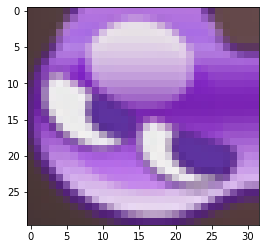

In [9]:
puyo = get_cell(p1_field_centered, 11, 0)
plt.imshow(puyo)
plt.show()

## Scikit Image/Learn - Logistic Regression

In [10]:
classes = ['empty', 'garbage', 'red', 'green', 'blue', 'yellow', 'purple']
clf = joblib.load('neuralnet-50-50.joblib')

In [11]:
def predict(im: np.ndarray, classes):
    pred = clf.predict(im.reshape(1, 30 * 32 * 3)).item(0)
    return classes[pred]

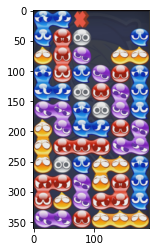

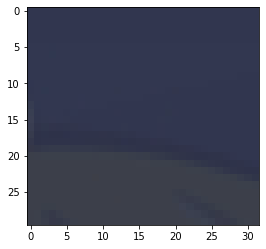

'empty'

In [12]:
p2_field = crop_im(im, field_rois[1])
p2_field_centered = crop_centered_field(p2_field)
plt.imshow(p2_field_centered)
plt.show()

puyo = get_cell(p2_field_centered, 1, 3)
plt.imshow(puyo)
plt.show()
predict(puyo, classes)

In [13]:
since = time.time()
cells = view_as_blocks(p2_field_centered, block_shape=(30, 32, 3))
cells = cells.reshape((12 * 6, -1))
preds = clf.predict(cells)
print('Prediction time: ', (time.time() - since) / (1 / 60), 'frames')

Prediction time:  2.519960403442383 frames


[['B' 'B' '0' '0' '0' '0']
 ['B' 'R' 'J' '0' '0' 'B']
 ['Y' 'R' 'P' '0' 'Y' 'Y']
 ['B' 'R' 'B' 'P' 'R' 'B']
 ['B' 'B' 'J' 'R' 'P' 'B']
 ['P' 'P' 'B' 'J' 'P' 'B']
 ['Y' 'P' 'B' 'B' 'R' 'P']
 ['Y' 'R' 'R' 'R' 'P' 'P']
 ['Y' 'J' 'B' 'Y' 'Y' 'B']
 ['R' 'R' 'P' 'Y' 'R' 'B']
 ['R' 'Y' 'P' 'R' 'R' 'B']
 ['P' 'P' 'R' 'Y' 'Y' 'Y']]


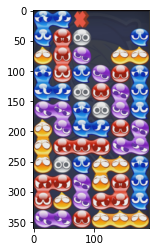

In [14]:
class_abbrev = np.array(['0', 'J', 'R', 'G', 'B', 'Y', 'P'])
print(class_abbrev[preds.reshape((12, 6))])
plt.imshow(p2_field_centered)
plt.show()

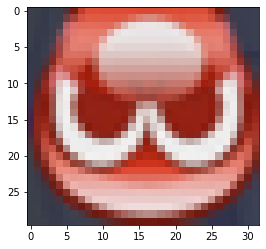

array([[-7.26594860e+01, -4.62809453e+01, -9.55034940e-10,
        -2.16522288e+02, -2.77952022e+02, -2.07692733e+01,
        -2.95738478e+02]])

In [15]:
puyo = get_cell(p2_field_centered, 3, 1)
plt.imshow(puyo)
plt.show()
clf.predict_log_proba(puyo.reshape(1, 30 * 32 * 3))

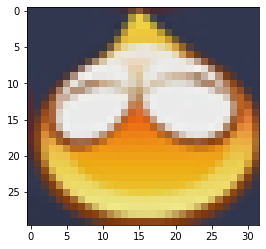

'yellow'

In [16]:
puyo = get_cell(p2_field_centered, 10, 1)
plt.imshow(puyo)
plt.show()
predict(puyo, classes)

## PyTorch

In [17]:
import torch
from torch import nn
from torchvision.transforms import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
# class PuyoClassifier(nn.Module):
#     def __init__(self):
#         super().__init__()        

#         self.conv = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3), # -> [-1, 32, 28, 30]
#             nn.ReLU(),
#             nn.Conv2d(32, 16, kernel_size=3), # -> [-1, 16, 26, 28]
#             nn.MaxPool2d(2) # -> [-1, 16, 13, 14]
#         )

#         self.fc = nn.Sequential(
#             nn.Linear(16 * 13 * 14, 7),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(-1, 16 * 13 * 14)
#         x = self.fc(x)
#         return x
class PuyoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2880, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 7),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 30)
        x = self.fc(x)
        return x

In [19]:
model = PuyoClassifier()
model.load_state_dict(torch.load('puyo-classifier-aug10b.pt'))
model.eval()
model.train(False)

PuyoClassifier(
  (fc): Sequential(
    (0): Linear(in_features=2880, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=7, bias=True)
    (5): ReLU()
  )
)

In [20]:
classes = np.array(['B', '0', 'J', 'G', 'P', 'R', 'Y'])
classes = np.array(['0', 'J', 'R', 'G', 'B', 'Y', 'P'])

In [23]:
# Apply the normalization PyTorch normally does.
cells = view_as_blocks(p2_field_centered, block_shape=(30, 32, 3))
cells = cells.reshape((-1, 30 * 32, 3)) / 255

since = time.time()
means = np.array([0.5, 0.5, 0.5])
stds = np.array([0.5, 0.5, 0.5])
cells_norm = (cells - means) / stds
cells_norm = cells_norm.reshape((-1, 30, 32, 3))
cells_norm = cells_norm.transpose((0, 3, 1, 2))
cells_norm = torch.as_tensor(cells_norm, dtype=torch.float)
cells_norm = cells_norm.contiguous()
print('Image transformation to tensor: ', (time.time() - since) / (1 / 60), 'frames')

Image transformation to tensor:  0.4199409484863281 frames


In [24]:
cells_norm.is_contiguous()

True

torch.Size([72, 3, 30, 32])
Inference Speed:  0.4200124740600586 frames
[['B' 'B' '0' '0' '0' '0']
 ['B' 'R' 'J' '0' '0' 'B']
 ['Y' 'R' 'P' '0' 'Y' 'Y']
 ['B' 'R' 'B' 'P' 'R' 'B']
 ['B' 'B' 'J' 'R' 'P' 'B']
 ['P' 'P' 'B' 'J' 'P' 'B']
 ['Y' 'P' 'B' 'B' 'R' 'P']
 ['Y' 'R' 'R' 'R' 'P' 'P']
 ['Y' 'J' 'B' 'Y' 'Y' 'B']
 ['R' 'R' 'P' 'Y' 'R' 'B']
 ['R' 'Y' 'P' 'R' 'R' 'B']
 ['P' 'P' 'R' 'Y' 'Y' 'Y']]


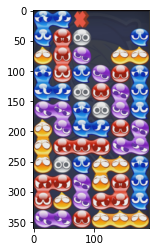

In [30]:
since = time.time()
print(cells_norm.shape)
preds = model(cells_norm)
print('Inference Speed: ', (time.time() - since) / (1 / 60), 'frames')
print(classes[torch.argmax(preds, axis=1)].reshape((12, 6)))
plt.imshow(p2_field_centered)
plt.show()

[['B' 'B' '0' '0' '0' '0']
 ['B' 'R' 'J' '0' '0' 'B']
 ['Y' 'R' 'P' '0' 'Y' 'Y']
 ['B' 'R' 'B' 'P' 'R' 'B']
 ['B' 'B' 'J' 'R' 'P' 'B']
 ['P' 'P' 'B' 'J' 'P' 'B']
 ['Y' 'P' 'B' 'B' 'R' 'P']
 ['Y' 'R' 'R' 'R' 'P' 'P']
 ['Y' 'J' 'B' 'Y' 'Y' 'B']
 ['R' 'R' 'P' 'Y' 'R' 'B']
 ['R' 'Y' 'P' 'R' 'R' 'B']
 ['P' 'P' 'R' 'Y' 'Y' 'Y']]


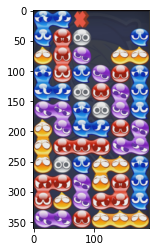

In [29]:
print(classes[torch.argmax(preds, axis=1)].reshape((12, 6)))
plt.imshow(p2_field_centered)
plt.show()

## Scikit-Learn Neural Network

In [31]:
classes = ['empty', 'garbage', 'red', 'green', 'blue', 'yellow', 'purple']
clf = joblib.load('neuralnet-50-50.joblib')

In [32]:
since = time.time()
cells = view_as_blocks(p2_field_centered, block_shape=(30, 32, 3))
cells = cells.reshape((12 * 6, -1))
preds = clf.predict(cells)
preds = clf.predict(cells) # If there's a second player
print('Prediction time: ', (time.time() - since) / (1 / 60), 'frames')

Prediction time:  1.2599658966064453 frames


[['B' 'B' '0' '0' '0' '0']
 ['B' 'R' 'J' '0' '0' 'B']
 ['Y' 'R' 'P' '0' 'Y' 'Y']
 ['B' 'R' 'B' 'P' 'R' 'B']
 ['B' 'B' 'J' 'R' 'P' 'B']
 ['P' 'P' 'B' 'J' 'P' 'B']
 ['Y' 'P' 'B' 'B' 'R' 'P']
 ['Y' 'R' 'R' 'R' 'P' 'P']
 ['Y' 'J' 'B' 'Y' 'Y' 'B']
 ['R' 'R' 'P' 'Y' 'R' 'B']
 ['R' 'Y' 'P' 'R' 'R' 'B']
 ['P' 'P' 'R' 'Y' 'Y' 'Y']]


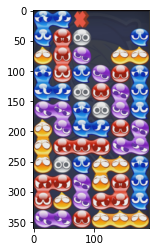

In [33]:
class_abbrev = np.array(['0', 'J', 'R', 'G', 'B', 'Y', 'P'])
print(class_abbrev[preds.reshape((12, 6))])
plt.imshow(p2_field_centered)
plt.show()